In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
import sys
import SimpleITK as sitk
import glob
import scipy.optimize
import scipy.ndimage
import skimage.metrics 

In [2]:
sys.path.append('..')
import CTProjector.projector.ct_projector as ct_projector
import model.unet as unet

In [100]:
import argparse
import configparser
parser = argparse.ArgumentParser()
parser.add_argument('--prj', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_full/L291.nii')
parser.add_argument('--geometry', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg')
parser.add_argument('--islices', type = int, nargs = 2, default = [50,51])
parser.add_argument('--N0', type = float, default = 2e5)
parser.add_argument('--dose_rate', type=float, default = 8)

parser.add_argument('--device', type = int, default = 0)
parser.add_argument('--img_norm', type = float, default = 0.019)
parser.add_argument('--train_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/l2_depth_3/')
parser.add_argument('--checkpoint', type=int, default = 50)
parser.add_argument('--tags', default = None)

if sys.argv[0] != 'noise2noise_ensemble.py':
    showplot = True
    args = parser.parse_args(['--device', '1', 
                              '--tags', 'dose_rate_2,dose_rate_4,dose_rate_8,dose_rate_12,dose_rate_16,all'])
else:
    showplot = False
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', getattr(args, k))

prj = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo_2d_3_layer_mean/prj_full/L291.nii
geometry = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg
islices = [50, 51]
N0 = 200000.0
dose_rate = 8
device = 1
img_norm = 0.019
train_dir = /home/dwu/trainData/deep_denoiser_ensemble/train/mayo_2d_3_layer_mean/l2_depth_3/
checkpoint = 50
tags = dose_rate_2,dose_rate_4,dose_rate_8,dose_rate_12,dose_rate_16,all


In [101]:
os.environ['CUDA_VISIBLE_DEVICES'] = '%d'%args.device
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [102]:
# first load data and do reconstruction
projector = ct_projector.ct_projector()
projector.from_file(args.geometry)
projector.nv = 1
for k in vars(projector):
    print (k, '=', getattr(projector, k))
angles = projector.get_angles()

nview = 2304
nu = 736
nv = 1
nx = 640
ny = 640
nz = 1
dx = 0.75
dy = 0.75
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aacfdb0ce80>


In [103]:
sitk_prjs = sitk.ReadImage(args.prj)
prj = sitk.GetArrayFromImage(sitk_prjs)[args.islices[0]:args.islices[1]] / args.img_norm
prj = prj[:, :, np.newaxis, :] # insert the v dimension

# reconstruct full dose image
fprj = projector.ramp_filter(prj)
ref = projector.fbp_fan_bp(fprj, angles) - 1

# noise insertion
np.random.seed(0)
if args.N0 > 0:
    prj = prj + np.sqrt((1 - 1 / args.dose_rate) * args.dose_rate * np.exp(prj * args.img_norm) / args.N0) * np.random.normal(size = prj.shape) / args.img_norm
    prj = prj.astype(np.float32)

In [104]:
# random splitting
inds_offset = np.random.randint(0, 2, prj.shape[1]//2)
inds1 = np.arange(0, prj.shape[1], 2) + inds_offset
inds2 = np.arange(0, prj.shape[1], 2) + (1 - inds_offset)
fprj = projector.ramp_filter(prj)
img1 = projector.fbp_fan_bp(np.copy(fprj[:, inds1, ...], 'C'), angles[inds1]) * 2
img2 = projector.fbp_fan_bp(np.copy(fprj[:, inds2, ...], 'C'), angles[inds2]) * 2
img = np.array([img1, img2]) - 1

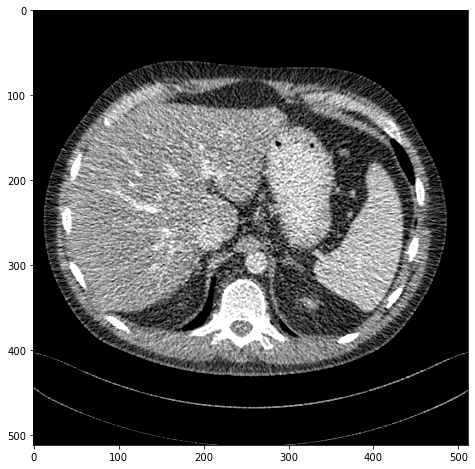

In [105]:
if showplot:
    plt.figure(figsize=[8,8])
    plt.imshow(img.mean(0)[0,0,64:-64,64:-64], 'gray', vmin=-0.16, vmax=0.24)

In [106]:
# load models and generate denoising results
# list model directories
if args.tags is None:
    tags = [os.path.basename(s) for s in glob.glob(os.path.join(args.train_dir, 'dose_rate_*'))]
else:
    tags = args.tags.split(',')
# the list of denoised images
base_imgs = [img]
K.clear_session()
print ('Predicting:', end=' ', flush=True)
for i, tag in enumerate(tags):
    print (i, end=',', flush=True)
    if tag == 'all':
        checkpoint = os.path.join(args.train_dir, tag, '4.h5')
    else:
        checkpoint = os.path.join(args.train_dir, tag, '%d.h5'%args.checkpoint)
    model = tf.keras.models.load_model(checkpoint)
    
    preds1 = model.predict(img[0, :, 0, :, :, np.newaxis])[...,0]
    preds2 = model.predict(img[1, :, 0, :, :, np.newaxis])[...,0]
    
    base_imgs.append(np.array([preds1[:, np.newaxis, :, :], preds2[:, np.newaxis, :, :]]))
base_imgs = np.array(base_imgs)

# predict using the corresponding dose rate and the all dose rate
print ('Matched network', end=',')
checkpoint = os.path.join(args.train_dir, 'dose_rate_%d'%args.dose_rate, '%d.h5'%args.checkpoint)
model = tf.keras.models.load_model(checkpoint)
pred_matched = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_matched = pred_matched[:, np.newaxis, :, :]

print ('Universal network', end=',')
checkpoint = os.path.join(args.train_dir, 'all/4.h5')
model = tf.keras.models.load_model(checkpoint)
pred_universal = model.predict(img.mean(0)[:, 0, :, :, np.newaxis])[..., 0]
pred_universal = pred_universal[:, np.newaxis, :, :]

Predicting: 0,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
1,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
2,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
3,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
4,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
5,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Matched network,WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Universal network,WARNING:tensorflow:No training configuration found in the save file, so the model

['dose_rate_2', 'dose_rate_4', 'dose_rate_8', 'dose_rate_12', 'dose_rate_16', 'all']


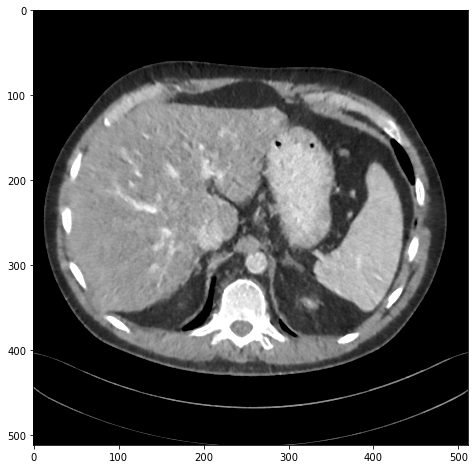

In [107]:
print (tags)
if showplot:
    plt.figure(figsize=[8,8])
    plt.imshow(pred_universal[0,0,64:-64,64:-64], 'gray', vmin=-0.16, vmax=0.24)

In [108]:
def process(img, vmin=-0.16, vmax=0.24):
    y = np.copy(img)
    y[y < vmin] = vmin
    y[y > vmax] = vmax
#     y = y - scipy.ndimage.gaussian_filter(y, 5)
    
    return y

In [137]:
M = np.zeros([len(base_imgs), len(base_imgs)])
b = np.zeros([len(base_imgs)])
gamma = 2
z1 = process(base_imgs[0, 0, ...])
z2 = process(base_imgs[0, 1, ...])

for k in range(len(base_imgs)):
    z1k = process(base_imgs[k, 0, ...])
    z2k = process(base_imgs[k, 1, ...])
    for i in range(len(base_imgs)):
        z1i = process(base_imgs[i, 0, ...])
        z2i = process(base_imgs[i, 1, ...])
        M[k, i] = np.sum(z1k * z1i) + np.sum(z2k * z2i) + gamma / 2 * np.sum((z1k + z2k) * (z1i + z2i))
        b[i] = np.sum(z2 * z1i) + np.sum(z1 * z2i) + gamma / 2 * np.sum((z1i + z2i) * (z1 + z2))
# c = np.linalg.solve(M, b)
c, _ = scipy.optimize.nnls(M, b)
c = np.array([0.0, 0, 0, 0, 0, 1, 0])
print (c)
res = np.sum(base_imgs.mean(1) * c[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis], 0)

[0. 0. 0. 0. 0. 1. 0.]


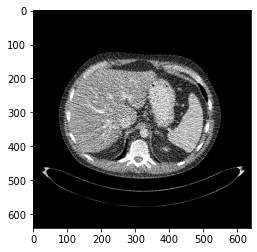

In [138]:
plt.imshow(z1[0,0], 'gray')

In [139]:
# extags = np.array([1] + [int(s.split('_')[-1]) for s in tags])

In [140]:
loss_fbp = np.sqrt(np.mean((img.mean(0) - ref)[..., 96:-96,96:-96]**2))
loss = np.sqrt(np.mean((res - ref)[..., 96:-96,96:-96]**2))
loss_matched = np.sqrt(np.mean((pred_matched - ref)[..., 96:-96,96:-96]**2))
loss_universal = np.sqrt(np.mean((pred_universal - ref)[..., 96:-96,96:-96]**2))

print (loss_fbp, loss, loss_matched, loss_universal)

0.047605753 0.021616904221582064 0.023117507 0.019789262


In [141]:
def calc_ssim(x, y, vmin=-0.16, vmax=0.24):
    x = (x - vmin) / (vmax - vmin)
    x[x < 0] = 0
    x[x > 1] = 1
    
    y = (y - vmin) / (vmax - vmin)
    y[y < 0] = 0
    y[y > 1] = 1
    
    return skimage.metrics.structural_similarity(x, y, data_range = 1)

In [142]:
ssim_fbp = calc_ssim(img.mean(0)[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_res = calc_ssim(res[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_matched = calc_ssim(pred_matched[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])
ssim_universal = calc_ssim(pred_universal[0, 0, 96:-96,96:-96], ref[0,0,96:-96,96:-96])

print (ssim_fbp, ssim_res, ssim_matched, ssim_universal)

0.579991317787804 0.729285989555191 0.7286444702689676 0.7426901036787024


['dose_rate_2', 'dose_rate_4', 'dose_rate_8', 'dose_rate_12', 'dose_rate_16', 'all']


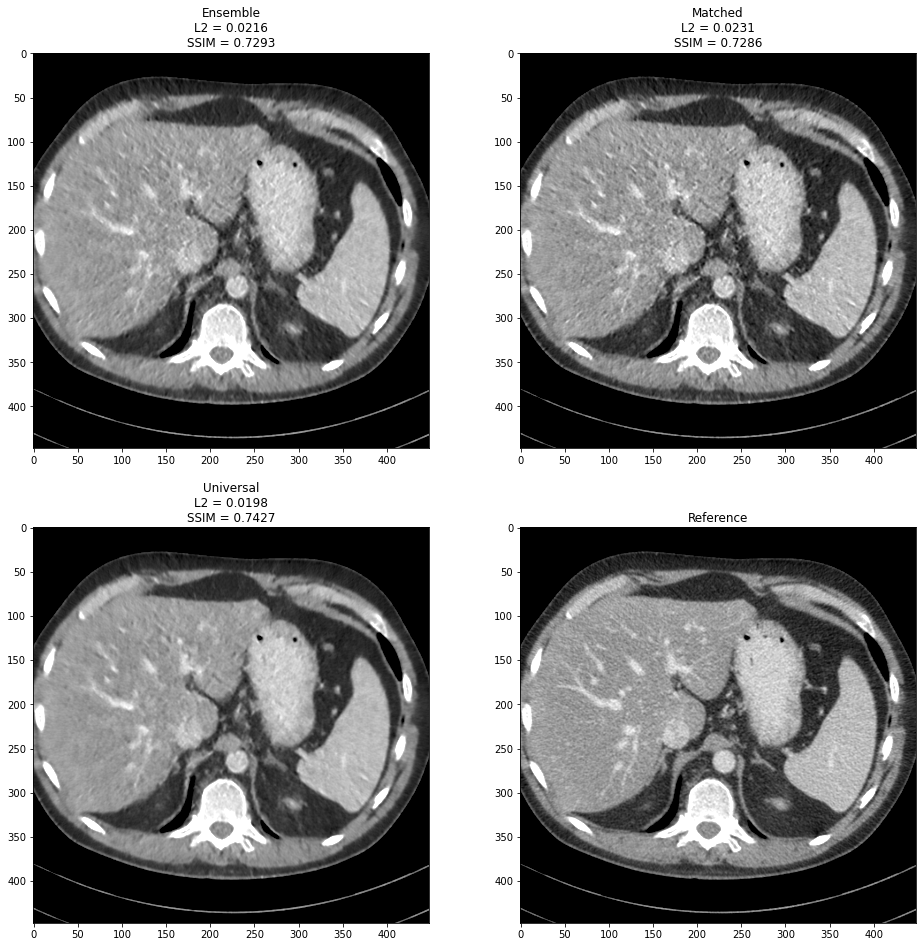

In [143]:
if showplot:
    print (tags)
    plt.figure(figsize=[16,16])
    plt.subplot(221); plt.imshow(res[0,0,96:-96,96:-96], 'gray', vmin=-0.16, vmax=0.24); plt.title('Ensemble\nL2 = %.4f\nSSIM = %.4f'%(loss, ssim_res))
    plt.subplot(222); plt.imshow(pred_matched[0,0,96:-96,96:-96], 'gray', vmin=-0.16, vmax=0.24); plt.title('Matched\nL2 = %.4f\nSSIM = %.4f'%(loss_matched, ssim_matched))
    plt.subplot(223); plt.imshow(pred_universal[0,0,96:-96,96:-96], 'gray', vmin=-0.16, vmax=0.24); plt.title('Universal\nL2 = %.4f\nSSIM = %.4f'%(loss_universal, ssim_universal))
    plt.subplot(224); plt.imshow(ref[0,0,96:-96,96:-96], 'gray', vmin=-0.16, vmax=0.24); plt.title('Reference')